In [1]:
import torch
import math
import random
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import os
import glob
from PIL import Image
from torch import optim, nn
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
%%bash
rm -rf images

In [3]:
%%bash
mkdir images
wget -O images/Dataset.zip https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip 
mkdir images/original
unzip -d images/Dataset/ images/Dataset.zip
ls -v images/Dataset/Flicker8k_Dataset/ | cat -n | while read n f; do mv -n "images/Dataset/Flicker8k_Dataset/$f" "images/original/$n.jpg"; done
wget -O images/watermark.png https://drive.google.com/uc?id=19g2xehk2ygH4WWZu6G7ir883NNtVyjjo&export=download
mkdir images/watermarked
mkdir images/not_watermarked
mkdir images/watermark_locations/
rm -rf images/Dataset
rm -rf images/Dataset.zip

Output hidden; open in https://colab.research.google.com to view.

In [4]:
%%bash
ls -l images/original/ | grep -v ^d | wc -l

8092


In [5]:
def gen_watermark(og_img_path, watermark_img_path, output_path, not_marked_path, watermark_locations_path, w, h):
  # Read the original image + dimension
  og_img = glob.glob(og_img_path)

  print('Adding watermarks')
  samples = 0

  # Original image resizing dims
  resize_w = w
  resize_h = h

  total_means = [0, 0, 0]
  total_vars = [0, 0, 0]

  for i in og_img:
      img = Image.open(i)
      img = img.resize((resize_w, resize_h))
      img_w, img_h = img.size

      samples += 1

      filename = os.path.basename(i)
      number = int(filename.split('.')[0])
      # Save resized original image
      img.save(not_marked_path + filename)

      for colour in range(3):
        pixels = np.asarray(img.getdata(colour))
        pixels = pixels/255
        total_means[colour] += np.mean(pixels)
        total_vars[colour] += np.var(pixels)

      # Read the watermark image + dimension
      watermark = Image.open(watermark_img_path)

      WM_SIZE = random.choice([1.1, 1.2, 1.3])
      # Resize the watermark in proportion to original image
      basewidth = int(img_w // WM_SIZE)
      wpercent = (basewidth / float(watermark.size[0]))
      hsize = int((float(watermark.size[1]) * float(wpercent)))
      watermark = watermark.resize((basewidth, hsize), Image.ANTIALIAS)

      # If watermark image is not a PNG
      if watermark.mode!='RGBA':
          alpha = Image.new('L', watermark.size, 255)
          watermark.putalpha(alpha)

      watermark_w, watermark_h = watermark.size

      # Randomly assign watermark coordinates
      water_w, water_h = (random.randint(0, img_w - watermark_w), random.randint(0, img_h - watermark_h))

      coords = torch.ones(resize_h, resize_w)
      coords[water_h:water_h+watermark_h, water_w:water_w + watermark_w] = 0
      torch.save(coords, open(watermark_locations_path + filename, 'wb'))
                
      # Randomly select transparency
      TRANSPARENCY = random.randint(40, 100)
      paste_mask = watermark.split()[3].point(lambda i: i * TRANSPARENCY / 100.)
      img.paste(watermark, (water_w, water_h), mask=paste_mask)
      
      filename = os.path.basename(i)
      # Save watermarked image
      img.save(output_path + filename)

  print('Watermark added to {} images'.format(samples))
  for colour in range(3):
    total_means[colour] = total_means[colour]/samples
    total_vars[colour] = math.sqrt(total_vars[colour]/samples)
  print('Pixel mean (RGB):', total_means)
  print('Pixel standard deviation (RGB):', total_vars)
  return samples, tuple(total_means), tuple(total_vars)

In [6]:
width=32#400
height=32#400
colors=3
og_img_path = 'images/original/*.*'
watermark_img_path = 'images/watermark.png'
output_path = 'images/watermarked/'
not_marked_path = 'images/not_watermarked/'
watermark_location_path='images/watermark_locations/'
samples, pixel_mean, pixel_standard_deviation = gen_watermark(og_img_path, watermark_img_path, output_path, not_marked_path, watermark_location_path, width, height)

Adding watermarks
Watermark added to 8091 images
Pixel mean (RGB): [0.4580541915331678, 0.4461163507026988, 0.40392402375415204]
Pixel standard deviation (RGB): [0.21813295203451566, 0.20999056206753547, 0.2164052753414522]


In [ ]:
class watermarkDataset:
  def __init__(self, original_path, watermarked_path, len, watermark_location_path, transform=None, output_transform=None):
        self.original_path = original_path
        self.watermarked_path = watermarked_path
        self.length = len
        self.transform = transform
        self.output_transform = output_transform
        self.watermark_location_path = watermark_location_path

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    # print(idx)
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx +=1
    original_img_name = os.path.join(self.original_path,
                            str(idx) + '.jpg')
    watermarked_img_name = os.path.join(self.watermarked_path,
                            str(idx) + '.jpg')
    watermark_location_name = os.path.join(self.watermark_location_path,
                            str(idx) + '.jpg')

    original_image = Image.open(original_img_name)
    watermarked_image = Image.open(watermarked_img_name)
    watermark_location = torch.load(open(watermark_location_name, 'rb'))
    if original_image is None or watermarked_image is None:
      print(original_img_name)
      print(watermarked_img_name)

    if self.transform:
      original_image = self.transform(original_image)
    if self.output_transform:
      watermarked_image = self.output_transform(watermarked_image)

    return original_image, watermarked_image, watermark_location

In [ ]:
tform = transforms.Compose([transforms.ToTensor() ,transforms.Normalize(pixel_mean, pixel_standard_deviation)])

data = watermarkDataset('images/not_watermarked/',
                        'images/watermarked/',
                        len=samples,
                        watermark_location_path=watermark_location_path,
                        transform=tform,
                        output_transform=tform)

In [ ]:
def get_data_loader(data, batch_size):
  train_data, validation_data = torch.utils.data.random_split(data, [samples - 1000, 1000])
  loader_kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }
  train_loader = DataLoader(train_data, **loader_kwargs)
  val_loader = DataLoader(validation_data, **loader_kwargs)
  return train_loader, val_loader

In [10]:
class our_loss():
  def __init__(self, watermark_weight):
    self.watermark_weight = watermark_weight

  def evaluate(self, source, target, locations):
    locations[locations==0] = self.watermark_weight
    locations = torch.unsqueeze(locations, 1)
    loss = source-target
    loss = loss * locations
    loss = torch.square(loss)
    loss = loss.sum()
    return loss

In [11]:
class unnormalize_data():
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def denorm(self, data):
    for colour in range(3):
      data[:, colour, :, :] = data[:, colour, :, :] * self.std[colour] + self.mean[colour]
    return data

In [12]:
def reshape(images):
  batch = images.shape[0]
  color_channel = images.shape[1]
  h = images.shape[2]
  w = images.shape[3]
  return images.reshape((w*h, batch, color_channel))

In [13]:
def reverse_reshape(images, shape_like):
  batch = shape_like.shape[0]
  color_channel = shape_like.shape[1]
  h = shape_like.shape[2]
  w = shape_like.shape[3]
  return images.reshape((batch, color_channel, h, w))

In [14]:
def eval_acc(model, data_loader, unnorm, loss_func, num_samples=5):
  count = 0
  val_acc = 0
  with torch.no_grad():
    model.eval()
    for batch, data in enumerate(data_loader):
      data = [d.cuda() for d in data]
      original, watermarked, locations = data
      # reshaped_original = reshape(original)
      reshaped_watermarked = reshape(watermarked)
      pred = model(reshaped_watermarked)#, reshaped_original)
      pred = reverse_reshape(pred, original)
      pred = unnorm.denorm(pred)
      original = unnorm.denorm(original)
      watermarked = unnorm.denorm(watermarked)
      val_acc += loss_func.evaluate(original, pred, locations)
      count +=1
      if batch < num_samples:
        print(f'=== Sample {batch + 1} ===')
        print('input:')
        pil_image = transforms.ToPILImage()(watermarked[0])
        display(pil_image)
        print('target:')
        pil_image = transforms.ToPILImage()(original[0])
        display(pil_image)
        print('pred:')
        pil_image = transforms.ToPILImage()(pred[0])
        display(pil_image)
  return val_acc/count

In [15]:
def train(model, train_loader, val_loader, unnorm, num_epochs, lr, loss_func):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  loss_history = []
  for epoch in range(num_epochs):
    current_loss = 0.0
    val_acc = eval_acc(model, val_loader, unnorm, loss_func, num_samples=0)
    for batch, data in enumerate(train_loader):
      data = [d.cuda() for d in data]
      original, watermarked, locations = data
      optimizer.zero_grad()
      reshaped_original = reshape(original)
      reshaped_watermark = reshape(watermarked)
      pred = model(reshaped_watermark)#, reshaped_original)
      pred = reverse_reshape(pred, original)
      loss = loss_func.evaluate(original, pred, locations)
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
      loss_history.append(loss.item())
      with torch.no_grad():
        loss_history.append(loss.item())
        if batch == 0:
          print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
            epoch, loss.item(), val_acc))
  
  return model, loss_history

In [16]:
torch.manual_seed(0)
torch.cuda.empty_cache()

batch_size = 50
num_epochs = 1000
learning_rate = 0.0001

set_unnorm =  unnormalize_data(pixel_mean, pixel_standard_deviation)
my_loss = our_loss(watermark_weight=2)

train_loader, val_loader = get_data_loader(data, batch_size)
# model = nn.Transformer(d_model = colors, nhead=3)
encoder_layer = nn.TransformerEncoderLayer(d_model=colors, nhead=3)
model = nn.TransformerEncoder(encoder_layer, num_layers=6)
model = model.cuda()

model, loss_history = train(model, train_loader, val_loader, set_unnorm, num_epochs, learning_rate, my_loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch:   0 	 Loss: 578060.062500 	 Val Acc: 28276.240234
Train Epoch:   1 	 Loss: 568740.187500 	 Val Acc: 26225.035156
Train Epoch:   2 	 Loss: 586377.625000 	 Val Acc: 25879.236328
Train Epoch:   3 	 Loss: 550925.187500 	 Val Acc: 25557.792969
Train Epoch:   4 	 Loss: 552458.750000 	 Val Acc: 25258.416016
Train Epoch:   5 	 Loss: 538402.375000 	 Val Acc: 24959.333984
Train Epoch:   6 	 Loss: 551599.062500 	 Val Acc: 24655.212891
Train Epoch:   7 	 Loss: 473051.750000 	 Val Acc: 24316.906250
Train Epoch:   8 	 Loss: 474229.625000 	 Val Acc: 23941.638672
Train Epoch:   9 	 Loss: 508055.406250 	 Val Acc: 23553.330078
Train Epoch:  10 	 Loss: 510336.531250 	 Val Acc: 23156.021484
Train Epoch:  11 	 Loss: 495122.656250 	 Val Acc: 22770.820312
Train Epoch:  12 	 Loss: 458882.343750 	 Val Acc: 22397.345703
Train Epoch:  13 	 Loss: 474551.625000 	 Val Acc: 22031.507812
Train Epoch:  14 	 Loss: 507207.531250 	 Val Acc: 21682.814453
Train Epoch:  15 	 Loss: 495129.593750 	 Val Acc: 21356

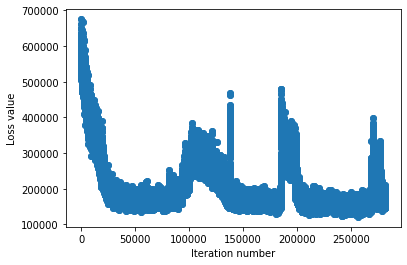

In [17]:
plt.plot(loss_history, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=== Sample 1 ===
input:


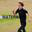

target:


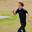

pred:


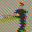

=== Sample 2 ===
input:


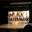

target:


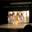

pred:


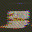

=== Sample 3 ===
input:


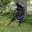

target:


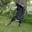

pred:


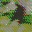

=== Sample 4 ===
input:


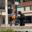

target:


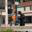

pred:


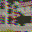

=== Sample 5 ===
input:


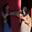

target:


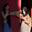

pred:


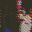

=== Sample 6 ===
input:


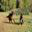

target:


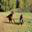

pred:


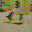

=== Sample 7 ===
input:


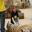

target:


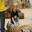

pred:


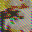

=== Sample 8 ===
input:


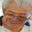

target:


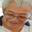

pred:


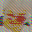

=== Sample 9 ===
input:


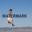

target:


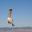

pred:


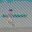

=== Sample 10 ===
input:


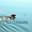

target:


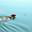

pred:


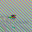

=== Sample 11 ===
input:


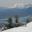

target:


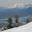

pred:


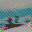

=== Sample 12 ===
input:


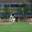

target:


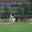

pred:


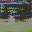

=== Sample 13 ===
input:


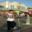

target:


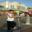

pred:


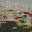

=== Sample 14 ===
input:


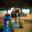

target:


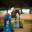

pred:


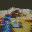

=== Sample 15 ===
input:


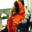

target:


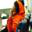

pred:


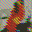

=== Sample 16 ===
input:


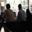

target:


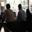

pred:


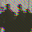

=== Sample 17 ===
input:


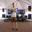

target:


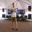

pred:


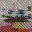

=== Sample 18 ===
input:


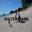

target:


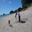

pred:


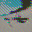

=== Sample 19 ===
input:


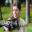

target:


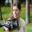

pred:


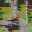

=== Sample 20 ===
input:


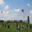

target:


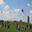

pred:


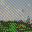

=== Sample 21 ===
input:


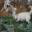

target:


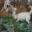

pred:


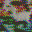

=== Sample 22 ===
input:


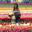

target:


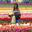

pred:


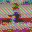

=== Sample 23 ===
input:


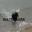

target:


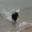

pred:


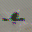

=== Sample 24 ===
input:


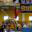

target:


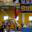

pred:


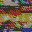

=== Sample 25 ===
input:


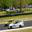

target:


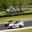

pred:


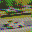

=== Sample 26 ===
input:


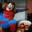

target:


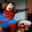

pred:


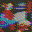

=== Sample 27 ===
input:


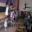

target:


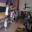

pred:


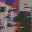

=== Sample 28 ===
input:


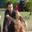

target:


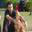

pred:


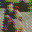

=== Sample 29 ===
input:


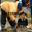

target:


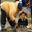

pred:


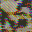

=== Sample 30 ===
input:


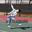

target:


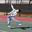

pred:


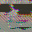

=== Sample 31 ===
input:


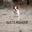

target:


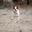

pred:


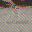

=== Sample 32 ===
input:


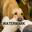

target:


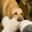

pred:


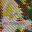

=== Sample 33 ===
input:


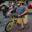

target:


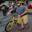

pred:


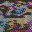

=== Sample 34 ===
input:


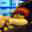

target:


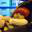

pred:


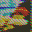

=== Sample 35 ===
input:


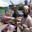

target:


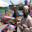

pred:


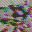

=== Sample 36 ===
input:


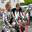

target:


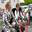

pred:


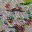

=== Sample 37 ===
input:


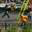

target:


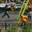

pred:


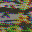

=== Sample 38 ===
input:


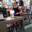

target:


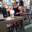

pred:


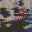

=== Sample 39 ===
input:


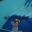

target:


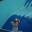

pred:


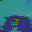

=== Sample 40 ===
input:


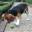

target:


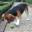

pred:


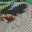

=== Sample 41 ===
input:


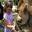

target:


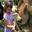

pred:


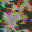

=== Sample 42 ===
input:


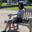

target:


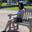

pred:


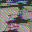

=== Sample 43 ===
input:


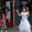

target:


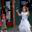

pred:


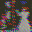

=== Sample 44 ===
input:


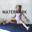

target:


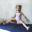

pred:


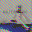

=== Sample 45 ===
input:


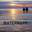

target:


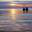

pred:


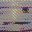

=== Sample 46 ===
input:


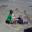

target:


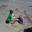

pred:


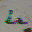

=== Sample 47 ===
input:


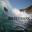

target:


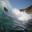

pred:


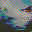

=== Sample 48 ===
input:


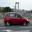

target:


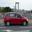

pred:


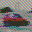

=== Sample 49 ===
input:


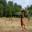

target:


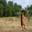

pred:


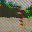

Training Accuracy: tensor(7625.7241, device='cuda:0')


In [18]:
train_acc = eval_acc(model, train_loader, set_unnorm, my_loss, num_samples=49)
print('Training Accuracy:', train_acc)